# 중고차 가격 예측
데이터 출처 : https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=vw.csv  
수정 데이터 출처 : https://www.datamanim.com/dataset/03_dataq/typetwo.html#id16  

x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_train.csv  
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_test.csv  
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_test.csv  

project file(.ipynb) : https://github.com/fa-ina-tic/report/blob/main/UsedCar.ipynb

In [1]:
# package load
import pandas as pd
import numpy as np

# data load
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_train.csv")
# x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_test.csv")

#import data 확인
display(x_train.head())
display(y_train.head())

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0


,carID,price
0,13207,31995
1,17314,7700
2,12342,58990
3,13426,12999
4,16004,16990


# EDA

순서
1. 결측값 확인
2. 이상값 확인
3. 데이터 타입 정리(category, datetime, string 주의하여서)

In [2]:
target = ['brand', 'model', 'transmission', 'fuelType']

for c in target:
    %timeit x_train.groupby(c)['tax'].sum()

261 µs ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
283 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
270 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
255 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
for c in target:
    x_train[c] = x_train[c].astype('category')
    %timeit x_train.groupby(c)['tax'].sum()
    x_train[c] = x_train[c].astype('object')

129 µs ± 215 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
126 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
142 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
146 µs ± 219 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
for c in target:
    x_train[c] = x_train[c].astype('category')

In [2]:
# data 기본 정보 확인
# X : 9 Columns 4960 Rows Null = None
# Y : 2 Columns 4960 Rows Null = None
print(x_train.info())
print(y_train.info())
print(x_test.info())

print(x_train.describe())
print(y_train.describe())
print(x_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         4960 non-null   int64  
 1   brand         4960 non-null   object 
 2   model         4960 non-null   object 
 3   year          4960 non-null   int64  
 4   transmission  4960 non-null   object 
 5   mileage       4960 non-null   int64  
 6   fuelType      4960 non-null   object 
 7   tax           4960 non-null   float64
 8   mpg           4960 non-null   float64
 9   engineSize    4960 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 387.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   carID   4960 non-null   int64
 1   price   4960 non-null   int64
dtypes: int64(2)
memory usage: 77.6 KB
None
<class 'pandas.cor

In [8]:
# 결측값
print(x_train.isnull().sum())
print(y_train.isnull().sum())

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64
carID    0
price    0
dtype: int64


In [37]:
drop_idx = x_train[(x_train['engineSize'] == 0) & ((x_train['fuelType'] == 'Diesel') | (x_train['fuelType'] == 'Petrol'))].index 

x_train.drop(drop_idx, inplace=True)
print(x_train.shape)

(4948, 10)


In [38]:
y_train.drop(drop_idx, inplace=True)
print(y_train.shape)

(4948, 2)


In [4]:
# 이상값

# 이상값 제거 함수 정의
def get_outliers(df=None, column=None, weight=1.5):
    per_75 = np.percentile(df[column].values, 75)
    per_25 = np.percentile(df[column].values, 25)
    
    IQR = (per_75 - per_25) * weight
    high = per_75 + IQR
    low = per_25 - IQR
    
    outlier_idx = df[(df[column]>high)|(df[column]<low)].index
    return outlier_idx

In [5]:
x_train.columns

Index(['carID', 'brand', 'model', 'year', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize'],
      dtype='object')

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

cate_col = ['brand', 'model', 'transmission', 'fuelType']
con_col = ['year', 'mileage','tax', 'mpg', 'engineSize']

for i in cate_col:
    fig = px.histogram(x_train, x=x_train[i])
    fig.show()

In [44]:
drop_idx_2 = x_train[(x_train['transmission']=='Other')|(x_train['fuelType'] == 'Other')|(x_train['fuelType'] == 'Electric')].index 

x_train.drop(drop_idx_2, inplace=True)
y_train.drop(drop_idx_2, inplace=True)
print(x_train.shape) #(4919, 10)
print(y_train.shape) #(4919, 2)

(4919, 10)
(4919, 2)


In [25]:
for i in con_col:
    fig = px.histogram(x_train, x=x_train[i])
    fig.show()

In [55]:
for i in con_col:
    boxplot = px.box(x_train, y=x_train[i])
    boxplot.show()

In [7]:
# mileage, mpg column에 로그를 취하여 머신 러닝의 성능을 높인다.
import numpy as np

log_features = ['mileage', 'mpg']

for i in log_features:
    x_train[i] = x_train[i].apply(lambda x: np.log1p(x))
    x_test[i] = x_test[i].apply(lambda x: np.log1p(x))


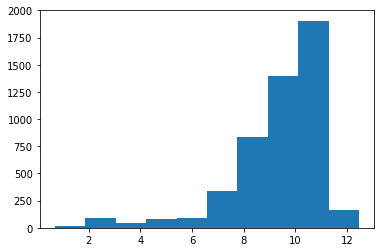

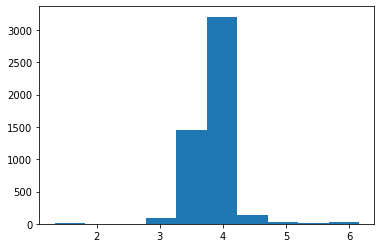

In [8]:
for i in log_features:
    plt.hist(x = x_train[[i]])
    plt.show()

In [9]:
for i in ['mileage', 'tax', 'mpg', 'engineSize']:
    outliers = get_outliers(x_train, i, 2)
    x_train.drop(outliers, axis=0, inplace=True)
    y_train.drop(outliers, axis=0, inplace=True)

In [10]:
# data type

# 명목변수 분리 
cate_col = ['brand', 'model', 'year', 'transmission', 'fuelType']

# string / float&int
string_col = ['brand', 'model', 'transmission', 'fuelType']
num_col = list(x_train.columns.drop(string_col))

In [11]:
# 명목 변수 data type category로 변경
for i in cate_col:
    x_train[i] = x_train[i].astype('category')
    x_test[i] = x_test[i].astype('category')
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3070 entries, 0 to 4959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   carID         3070 non-null   int64   
 1   brand         3070 non-null   category
 2   model         3070 non-null   category
 3   year          3070 non-null   category
 4   transmission  3070 non-null   category
 5   mileage       3070 non-null   float64 
 6   fuelType      3070 non-null   category
 7   tax           3070 non-null   float64 
 8   mpg           3070 non-null   float64 
 9   engineSize    3070 non-null   float64 
dtypes: category(5), float64(4), int64(1)
memory usage: 163.0 KB
None


In [12]:
# train과 test에 명목 변수가 다 같이 있는지 확인
train_dum = pd.get_dummies(x_train[cate_col])
test_dum = pd.get_dummies(x_test[cate_col])

print(set(train_dum.columns) - set(test_dum.columns))
print(set(test_dum.columns) - set(train_dum.columns))

{'model_ M6'}
{'year_1998', 'model_ Z3', 'year_2001', 'fuelType_Electric', 'model_ Antara', 'year_2002', 'model_ Hilux', 'model_ R8', 'model_ M Class', 'model_ i3', 'model_ Fusion', 'year_2003', 'year_1970', 'model_ CLK', 'model_ IQ', 'model_ Amarok', 'model_ i8', 'model_ California'}


In [13]:
# 없는 명목변수를 포함하는 train, test 테이블 생성
X_train_dum = pd.get_dummies(x_train)
X_test_dum = pd.get_dummies(x_test)

train_missing = set(test_dum.columns) - set(train_dum.columns)
test_missing = set(train_dum.columns) - set(test_dum.columns)

for c in train_missing:
    X_train_dum[c] = 0
for c in test_missing:
    X_test_dum[c] = 0

# Model Selection

최적의 Hyperparameter를 가진 Model을 탐색한다.
Model = XGBREgressor
Tuned Hyperparameter = depth, learning_rate, n_estimators, gamma

In [14]:
# package import
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [28]:
X = X_train_dum.iloc[:, 1:]
y = y_train.iloc[:, 1:]

kfold = KFold(n_splits=5, shuffle=True)
pipe = Pipeline(steps=[('model', XGBRegressor(eval_metric='mlogloss', use_label_encoder=False))])
grid_params = {'model':[XGBRegressor(eval_metric='mlogloss', use_label_encoder=False)],
               'model__max_depth':[3, 5, 7],
               'model__learning_rate':[0.1, 0.2, 0.3],
               'model__n_estimators':[50, 100, 200, 300]}

grid = GridSearchCV(pipe, grid_params, cv=kfold, verbose=0)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mlogloss', gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300}
0.9604278776648874


# Modeling

Modeling후 성능 평가

In [24]:
model = XGBRegressor(eval_metric='mlogloss', use_label_encoder=False,
                      learning_rate=0.2, max_depth=5, n_estimators=300, gamma=0)
model.fit(X, y)
pred = model.predict(X_test_dum.iloc[:, 1:])
pred = pd.Series(pred)

answer = pd.concat([X_test_dum.carID, pred], axis=1)

In [25]:
answer

,carID,0
0,12000,38623.234375
1,12001,32896.031250
2,12004,50333.730469
3,12013,17442.408203
4,12017,81485.320312
...,...,...
2667,19618,74106.445312
2668,19620,16887.019531
2669,19626,16722.974609
2670,19630,25908.457031


In [26]:
x_label = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_test.csv")

display(x_label.head())

,carID,price
0,12000,38000
1,12001,23495
2,12004,59999
3,12013,16713
4,12017,46000


In [27]:
#Scoring
from sklearn.metrics import r2_score

score = r2_score(x_label.price, answer.iloc[:, 1])
print(score)

0.7087962561434745
